In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
from scipy.stats import pearsonr
import optuna
import plotly
import nbformat

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

c:\Users\lysov\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function, fill NA in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
data = pd.read_excel("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/data_tf.xlsx", decimal = ',', parse_dates=["date"])
metadata = pd.read_csv("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/meta_data.csv", delimiter = ";")
data_num = data.loc[:, data.columns != 'date']

target_variable = "gdp"

lags = list(range(-2, 3))

train_start_date = "2011-01-01"
train_end_date = "2018-12-01"
test_start_date = "2019-03-01"
test_end_date = "2023-09-01"

test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)


In [4]:
# names = ['date', 'gdp',
#          # sectors
#          'agri', 'mining', 'manufacturing', 'egpiv', 'construction', 'trade', 'transport', 'finance', 'real_estate', 'others', 'taxes',
#          # PMI
#          'PMI_Mnf', 'PMI_Serv', 'PMI_Comp',
#          # IBC total
#          'IBC_total',  'IBC_total_fact', 'IBC_total_3m', 'IBC_total_output', 'IBC_total_output_3m', 'IBC_total_demand',
#          'IBC_total_demand_3m', 'IBC_total_price', 'IBC_total_price_3m','IBC_total_costs', 'IBC_total_credit',
#          # IBC ip
#          'IBC_ip', 'IBC_ip_fact', 'IBC_ip_3m', 'IBC_ip_output', 'IBC_ip_output_3m', 'IBC_ip_demand',
#          'IBC_ip_demand_3m', 'IBC_ip_price', 'IBC_ip_price_3m', 'IBC_ip_costs', 'IBC_ip_credit', 
#          # IBC mining
#          'IBC_mining', 'IBC_mining_fact', 'IBC_mining_3m', 'IBC_mining_output', 'IBC_mining_output_3m', 'IBC_mining_demand',
#          'IBC_mining_demand_3m', 'IBC_mining_price', 'IBC_mining_price_3m', 'IBC_mining_costs', 'IBC_mining_credit',
#          # IBC manufacturing
#          'IBC_mnf', 'IBC_mnf_fact', 'IBC_mnf_3m', 'IBC_mnf_output', 'IBC_mnf_output_3m', 'IBC_mnf_demand',
#          'IBC_mnf_demand_3m', 'IBC_mnf_price', 'IBC_mnf_price_3m', 'IBC_mnf_costs', 'IBC_mnf_credit',
#          # IBC constr
#          'IBC_constr', 'IBC_constr_fact', 'IBC_constr_3m', 'IBC_constr_output','IBC_constr_output_3m', 'IBC_constr_demand',
#          'IBC_constr_demand_3m', 'IBC_constr_price', 'IBC_constr_price_3m', 'IBC_constr_costs', 'IBC_constr_credit',
#          # IBC trade
#          'IBC_trade', 'IBC_trade_fact', 'IBC_trade_3m', 'IBC_trade_output', 'IBC_trade_output_3m', 'IBC_trade_demand',
#          'IBC_trade_demand_3m', 'IBC_trade_price', 'IBC_trade_price_3m', 'IBC_trade_costs', 'IBC_trade_credit',
#          # IBC transp
#          'IBC_transp', 'IBC_transp_fact', 'IBC_transp_3m', 'IBC_transp_output', 'IBC_transp_output_3m', 'IBC_transp_demand', 
#          'IBC_transp_demand_3m', 'IBC_transp_price', 'IBC_transp_price_3m', 'IBC_transp_costs', 'IBC_transp_credit',
#          # IBC serv
#          'IBC_serv', 'IBC_serv_fact', 'IBC_serv_3m', 'IBC_serv_output', 'IBC_serv_output_3m', 'IBC_serv_demand',
#          'IBC_serv_demand_3m', 'IBC_serv_price', 'IBC_serv_price_3m', 'IBC_serv_costs', 'IBC_serv_credit',
#          # hse + rspp
#          'hse', 'rspp1', 'rspp2', 'rspp3', 'rspp4', 'rspp5', 'rspp6', 'rspp7',
#          # ipu rosstat
#          'ipu_constr1', 'ipu_constr2', 'ipu_constr3',
#          # ip
#          'ip', 'ip_raw',  'ip_coal', 'ip_oil_products',
#          'ip_chemicals', 'ip_man', 'ip_metals', 'ip_constr', 'ip_cars', 'ip_food', 'ip_nonfood', 'ip_el',
#          # rail + cargo
#          'rail', 'cargo_rail', 'cargo_auto', 'cargo_sea', 'cargo_pipe',
#          # constr
#          'constr_vol', 'constr_prices',
#          # serv
#          'retail_prod', 'retail_neprod', 'opt', 'selhoz', 'pserv', 'obschepit',
#          # labor
#          'dispinc', 'eap', 'unemp', 'nwage', 'rwage', 
#          # cars and invest
#          'cars', 'trucks', 'iok', 'ibved',
#          # financial
#          'miacr', 'rtc', 'moex', 'reer', 'rvi', 'm0', 'm2x', 'ofz1', 'ofz3', 'ofz5', 'ofz10',
#          # dep/cred rates 
#          'dep_hh_rate', 'dep_nfo_rate', 'cred_hh_rate', 'cred_nfo_rate',
#          # ust
#          't2', 't10',
#          # external conditions
#          'ism_man', 'ism_serv', 'us_cpi', 'eu_cpi', 'cpi', 'cpi_prod', 'cpi_neprod', 'cpi_serv', 'ppi',
#          'brent', 'urals', 'aluminium', 'gold', 'gas',
#          # food prices
#          'FAOFOODI', 'FAOFCER', 'FAOFMEAT', 'FAOFDARY', 'FAOFSUGR', 'FAOFOILS']

# data = data.loc[:, names]
# # train and test datasets
# test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

In [5]:
corr = data_num.corr(method='pearson')

# remove highly correlated predictors
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data_num.columns[columns].insert(0, 'date')

data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [4]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p

In [5]:
data_num = data.loc[:, data.columns != 'date']
pvals = r_pvalues(data_num)

In [8]:
selected_columns = data_num.loc[:, pvals[target_variable] < 0.3].columns
selected_columns = selected_columns.insert(0, 'date')
data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [6]:
def nowcast_xgboost(model_params, target_variable, dates, actuals):
    
    selected_columns = data_num.loc[:, pvals[target_variable] < model_params['pval']].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected

    pred_dict = {k: [] for k in lags}
    try:
        for date in dates:
            train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:] 
            transformed_train = mean_fill_dataset(train, train) 
            transformed_train = flatten_data(transformed_train, target_variable, model_params['flat'])
            transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
            
            models = []
            for i in range(5):
                model = XGBRegressor(
                    n_estimators = model_params['n_estimators'], #400
                    eta = model_params['eta'], # 0.0005
                    max_depth = model_params['max_depth'],
                    reg_lambda = model_params['reg_lambda'], # 0.3
                    reg_alpha = model_params['reg_alpha'], # 0.2
                    colsample_bytree = model_params['colsample_bytree'],
                    n_jobs = -1
                )

                x = transformed_train.drop(["date", target_variable], axis=1)
                y = transformed_train[target_variable]

                model.fit(x, y)
                models.append(model)

            for lag in lags:
                tmp_data = gen_lagged_data(metadata, test_t, date, lag)

                tmp_data = mean_fill_dataset(train, tmp_data)
                tmp_data = flatten_data(tmp_data, target_variable, model_params['flat'])
                x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
                
                preds = []
                for i in range(5):
                    prediction = models[i].predict(x)[0]
                    preds.append(prediction)
                
                pred_dict[lag].append(np.nanmean(preds))
        curr_MAE = np.mean(np.abs((np.array(actuals) - np.array(pred_dict[2]))))
    except: curr_MAE=1000
     
    return curr_MAE

In [7]:
def objective(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-2, 1)
    n_estimators = trial.suggest_int('n_estimators', 500, 1300, step=100)
    eta = trial.suggest_discrete_uniform('eta', 1e-3, 1, 0.05)
    max_depth = trial.suggest_int('max_depth', 2, 6, step=1)
    reg_alpha = trial.suggest_discrete_uniform('reg_alpha', 0, 1 , 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0, 1 , 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0, 1 , 0.1)

    #reg_alpha = 0
    #reg_lambda = 1

    flat = trial.suggest_int('flat', 2, 4, step=1)


    model_params = {'pval': pval, 'n_estimators': n_estimators, 'eta': eta, 'max_depth': max_depth,
                    'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda, 'colsample_bytree': colsample_bytree, 'flat': flat}
    
    return nowcast_xgboost(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    

In [8]:
def evaluate_xgboost(data, model_params, target_variable, plot, save):
    target_variable = target_variable
    
    n_estimators = model_params['n_estimators']
    eta = model_params['eta']
    max_depth = model_params['max_depth']
    reg_alpha = model_params['reg_alpha']
    reg_lambda = model_params['reg_lambda']
    colsample_bytree = model_params['colsample_bytree']
    pval = model_params['pval']
    flat = model_params['flat']
    
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected
    
    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
        transformed_train = mean_fill_dataset(train, train)
        transformed_train = flatten_data(transformed_train, target_variable, model_params['flat'])
        transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
        
        models = []
        for i in range(5):
            model = XGBRegressor(
                n_estimators = model_params['n_estimators'], #400
                eta = model_params['eta'], # 0.0005
                max_depth = model_params['max_depth'],
                reg_lambda = model_params['reg_lambda'], # 0.3
                reg_alpha = model_params['reg_alpha'], # 0.2
                colsample_bytree = model_params['colsample_bytree'],
                n_jobs = -1
            )

            x = transformed_train.drop(["date", target_variable], axis=1)
            y = transformed_train[target_variable]

            model.fit(x, y)
            models.append(model)

        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test_t, date, lag)

            tmp_data = mean_fill_dataset(train, tmp_data)
            tmp_data = flatten_data(tmp_data, target_variable, model_params['flat'])
            x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
            
            preds = []
            for i in range(5):
                prediction = models[i].predict(x)[0]
                preds.append(prediction)
            
            pred_dict[lag].append(np.nanmean(preds))
    
    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)
    
    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "actuals":actuals, 
            "two_back":pred_dict[-2], 
            "one_back":pred_dict[-1], 
            "zero_back":pred_dict[0],
            "one_ahead":pred_dict[1],
            "two_ahead":pred_dict[2]}
        )
        predictions_elastic.plot()

    if save == 1:
        predictions_elastic.to_excel(f"predictions_{target_variable}_xgboost.xlsx")
        

In [10]:
target_variable = 'gdp'
study = optuna.create_study()
study.optimize(objective, n_trials = 50)
gdp_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 01:22:49,522] A new study created in memory with name: no-name-faa01ccf-22af-489b-b85d-c672295e56a2
[I 2024-04-26 01:23:50,141] Trial 0 finished with value: 1.746530979175071 and parameters: {'pval': 0.000601320739498147, 'n_estimators': 500, 'eta': 0.0017138958528299165, 'max_depth': 3, 'reg_alpha': 0.5, 'reg_lambda': 0.2, 'flat': 4}. Best is trial 0 with value: 1.746530979175071.
[I 2024-04-26 01:24:55,568] Trial 1 finished with value: 1.6782521567153983 and parameters: {'pval': 0.004956461245573721, 'n_estimators': 500, 'eta': 0.002857720946796985, 'max_depth': 2, 'reg_alpha': 0.6, 'reg_lambda': 0.30000000000000004, 'flat': 3}. Best is trial 1 with value: 1.6782521567153983.
[I 2024-04-26 01:25:47,222] Trial 2 finished with value: 1.7463461147810964 and parameters: {'pval': 0.00029041779636421845, 'n_estimators': 500, 'eta': 0.0006677427127186951, 'max_depth': 3, 'reg_alpha': 0.4, 'reg_lambda': 0.6, 'flat': 3}. Best is trial 1 with value: 1.6782521567153983.
[I 2024-04

Best MAE=1.5447626871589664, best parameters:{'pval': 0.55509982843079, 'n_estimators': 400, 'eta': 0.009881716656641554, 'max_depth': 2, 'reg_alpha': 0.6, 'reg_lambda': 0.4, 'flat': 3}


In [ ]:
evaluate_xgboost(data = data, target_variable='gdp', model_params=gdp_opt, plot=1, save=0)

In [11]:
target_variable = 'agri'
study = optuna.create_study()
study.optimize(objective, n_trials = 50)
agri_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 03:26:51,062] A new study created in memory with name: no-name-69e21819-a5c7-48f2-8979-30ee983e9044
[I 2024-04-26 03:27:53,064] Trial 0 finished with value: 0.3230382763545087 and parameters: {'pval': 0.2492059389042017, 'n_estimators': 500, 'eta': 0.0007261464773240074, 'max_depth': 2, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'flat': 4}. Best is trial 0 with value: 0.3230382763545087.
[I 2024-04-26 03:27:53,101] Trial 1 finished with value: 1000.0 and parameters: {'pval': 0.005863587828028888, 'n_estimators': 450, 'eta': 0.007710541400568389, 'max_depth': 2, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'flat': 3}. Best is trial 0 with value: 0.3230382763545087.
[I 2024-04-26 03:27:53,128] Trial 2 finished with value: 1000.0 and parameters: {'pval': 7.937136143777679e-05, 'n_estimators': 400, 'eta': 0.0005038405088800004, 'max_depth': 2, 'reg_alpha': 0.6, 'reg_lambda': 0.6, 'flat': 4}. Best is trial 0 with value: 0.3230382763545087.
[I 2024-04-26 03:28:17,604] Trial 3

Best MAE=0.2998429529841846, best parameters:{'pval': 0.013132498748111461, 'n_estimators': 400, 'eta': 0.00041598907643405355, 'max_depth': 3, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'flat': 3}


  Vintage    RMSE     MAE
0      -2  0.4378  0.3207
1      -1  0.4378  0.3207
2       0  0.4377  0.3231
3       1  0.4377  0.3231
4       2  0.4361  0.2998


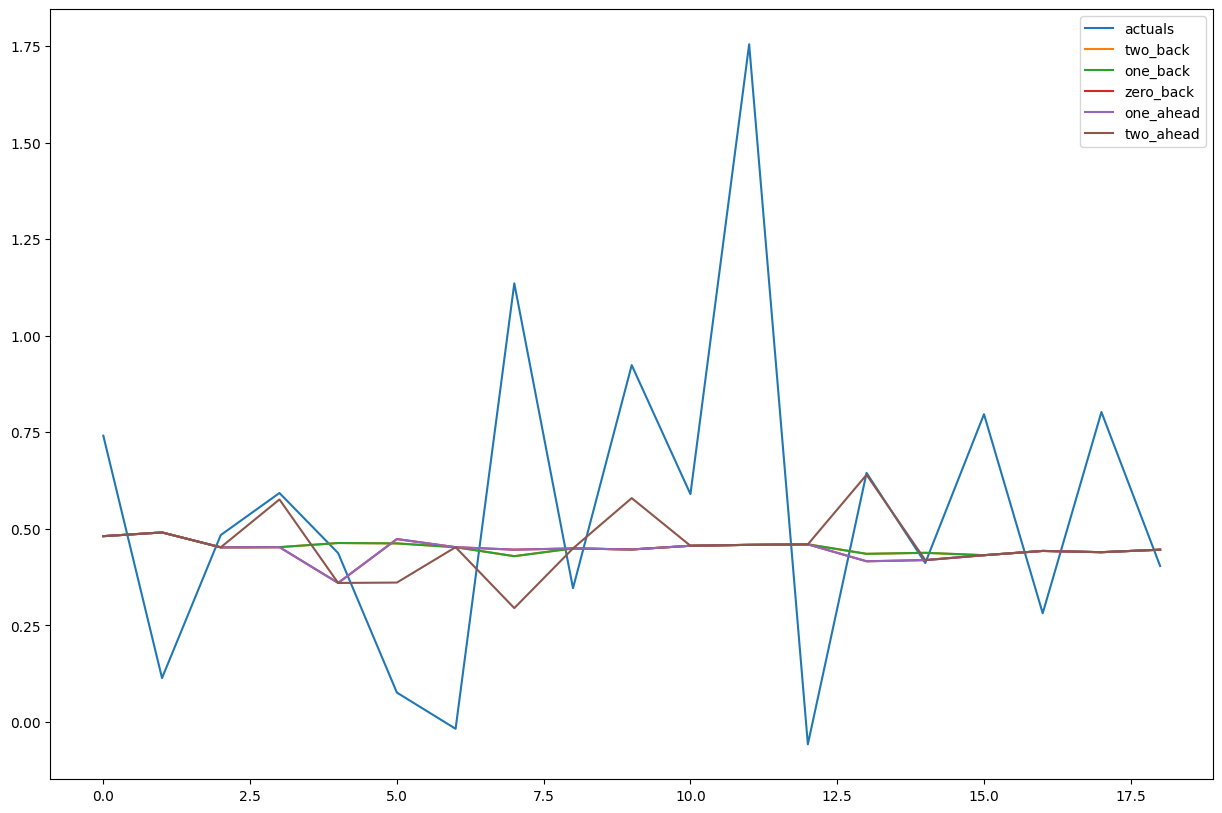

In [12]:
evaluate_xgboost(data = data, target_variable='agri', model_params=agri_opt, plot=1, save=1)

In [13]:
target_variable = 'mining'
study = optuna.create_study()
study.optimize(objective, n_trials = 50)
mining_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 03:46:52,857] A new study created in memory with name: no-name-3f933a4e-c0b2-446b-86a4-b659bdf69781
[I 2024-04-26 03:47:15,068] Trial 0 finished with value: 2.0645172229176305 and parameters: {'pval': 0.0003651063875586697, 'n_estimators': 500, 'eta': 0.0006818248733652512, 'max_depth': 2, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'flat': 4}. Best is trial 0 with value: 2.0645172229176305.
[I 2024-04-26 03:48:05,504] Trial 1 finished with value: 2.1363047089565 and parameters: {'pval': 0.022031519007847222, 'n_estimators': 450, 'eta': 0.002450136272992348, 'max_depth': 2, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'flat': 3}. Best is trial 0 with value: 2.0645172229176305.
[I 2024-04-26 03:49:24,104] Trial 2 finished with value: 2.0878124662373425 and parameters: {'pval': 0.02105844133276573, 'n_estimators': 500, 'eta': 0.0009151904807074727, 'max_depth': 3, 'reg_alpha': 0.6, 'reg_lambda': 0.4, 'flat': 4}. Best is trial 0 with value: 2.0645172229176305.
[I 2024-04-26

Best MAE=1.9853487902723657, best parameters:{'pval': 6.938959231687443e-05, 'n_estimators': 400, 'eta': 0.005557275299913855, 'max_depth': 3, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004, 'flat': 2}


In [ ]:
evaluate_xgboost(data = data, target_variable='mining', model_params=mining_opt, plot=1, save=1)

In [43]:
def objective_manufacturing(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    # actual values
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-3, 3e-1)
    n_estimators = trial.suggest_int('n_estimators', 500, 800, step=100)
    eta = trial.suggest_loguniform('eta', 1e-4, 1e-2)
    max_depth = trial.suggest_int('max_depth', 2, 5, step=1)
    reg_alpha = trial.suggest_discrete_uniform('reg_alpha', 0, 1, 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0, 1 , 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0, 0.3 , 0.05)

    #reg_alpha = 0
    #reg_lambda = 1

    flat = trial.suggest_int('flat', 2, 5, step=1)


    model_params = {'pval': pval, 'n_estimators': n_estimators, 'eta': eta, 'max_depth': max_depth,
                    'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda, 'colsample_bytree': colsample_bytree, 'flat': flat}
    
    return nowcast_xgboost(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    

In [44]:
target_variable = 'manufacturing'
study = optuna.create_study()
study.optimize(objective_manufacturing, n_trials = 150)
manufacturing_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 19:25:42,583] A new study created in memory with name: no-name-2f4bc92d-426f-4921-adff-c248a7907655


[I 2024-04-26 19:26:17,823] Trial 0 finished with value: 2.3220506047901908 and parameters: {'pval': 0.014008279986912365, 'n_estimators': 600, 'eta': 0.00010957129061415383, 'max_depth': 5, 'reg_alpha': 0.0, 'reg_lambda': 0.8, 'colsample_bytree': 0.15000000000000002, 'flat': 3}. Best is trial 0 with value: 2.3220506047901908.
[I 2024-04-26 19:26:49,857] Trial 1 finished with value: 2.3017462386282417 and parameters: {'pval': 0.046673293379859246, 'n_estimators': 700, 'eta': 0.00045713968268297446, 'max_depth': 3, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.8, 'colsample_bytree': 0.25, 'flat': 2}. Best is trial 1 with value: 2.3017462386282417.
[I 2024-04-26 19:27:51,107] Trial 2 finished with value: 2.2768442656614067 and parameters: {'pval': 0.11443750638573544, 'n_estimators': 500, 'eta': 0.0015062992502280549, 'max_depth': 3, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004, 'colsample_bytree': 0.3, 'flat': 4}. Best is trial 2 with value: 2.2768442656614067.
[I 2024-04-26 

Best MAE=2.032133399772603, best parameters:{'pval': 0.006662926856090486, 'n_estimators': 800, 'eta': 0.009084412468421104, 'max_depth': 5, 'reg_alpha': 0.2, 'reg_lambda': 0.6000000000000001, 'colsample_bytree': 0.1, 'flat': 3}


In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_parallel_coordinate(study)

In [47]:
optuna.visualization.plot_slice(study, params = ['pval', 'n_estimators', 'eta', 'max_depth',
                    'reg_alpha', 'reg_lambda', 'flat'])

In [48]:
optuna.visualization.plot_param_importances(study)

  Vintage    RMSE     MAE
0      -2  3.3798  2.2420
1      -1  3.2851  2.1374
2       0  3.2160  2.0561
3       1  3.2825  2.1357
4       2  3.0376  2.0321


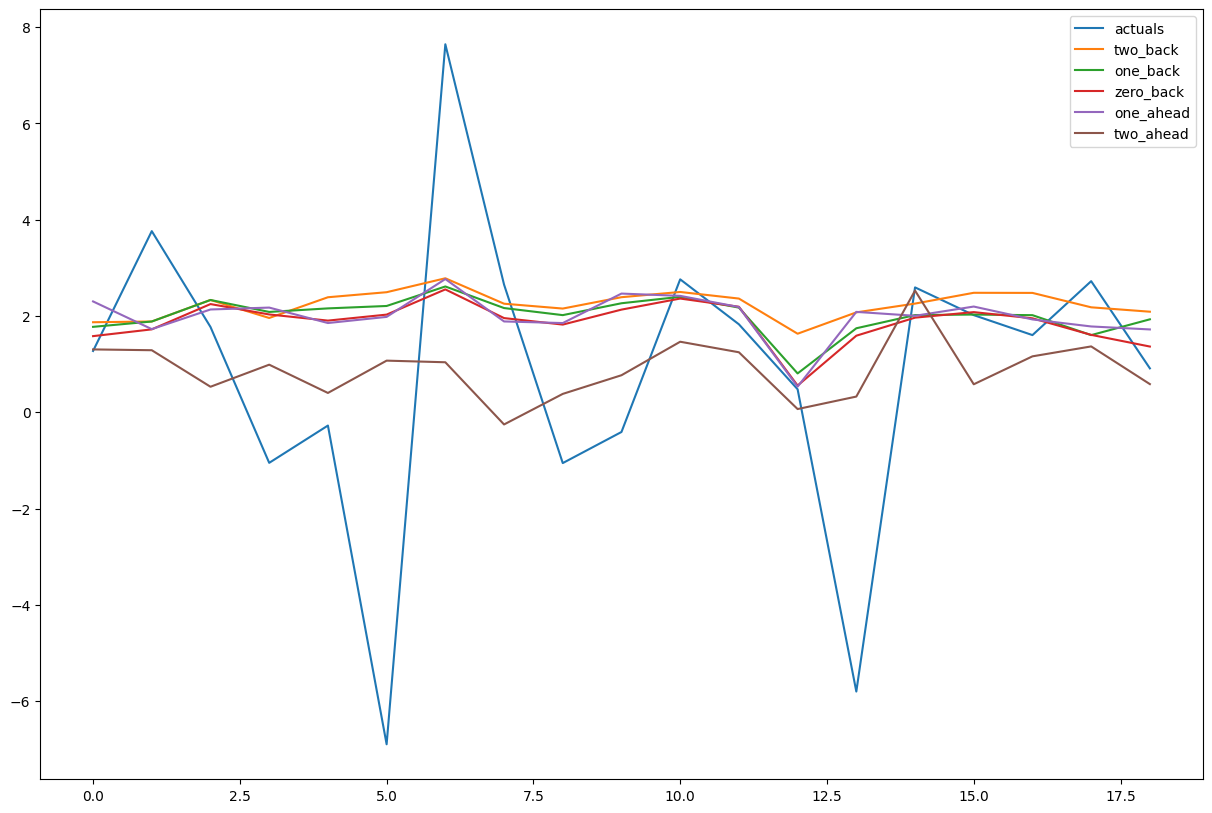

In [49]:
evaluate_xgboost(data = data, target_variable='manufacturing', model_params=manufacturing_opt, plot=1, save=1)

In [54]:
target_variable = 'egpiv'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
egpiv_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 00:54:25,884] A new study created in memory with name: no-name-ddfefa89-f763-4423-b16e-95d75f314718
[I 2024-04-27 01:00:36,189] Trial 0 finished with value: 1.1021020027901958 and parameters: {'pval': 0.3413682822363068, 'n_estimators': 1300, 'eta': 0.401, 'max_depth': 3, 'reg_alpha': 0.2, 'reg_lambda': 0.6000000000000001, 'colsample_bytree': 0.7000000000000001, 'flat': 4}. Best is trial 0 with value: 1.1021020027901958.
[I 2024-04-27 01:06:16,408] Trial 1 finished with value: 1.3502863513894148 and parameters: {'pval': 0.39915046553572886, 'n_estimators': 1300, 'eta': 0.8510000000000001, 'max_depth': 3, 'reg_alpha': 0.9, 'reg_lambda': 0.7000000000000001, 'colsample_bytree': 0.2, 'flat': 4}. Best is trial 0 with value: 1.1021020027901958.
[I 2024-04-27 01:06:41,841] Trial 2 finished with value: 1.3301734281408977 and parameters: {'pval': 0.026537615305271038, 'n_estimators': 900, 'eta': 0.951, 'max_depth': 2, 'reg_alpha': 0.9, 'reg_lambda': 0.4, 'colsample_bytree': 1.0, '

Best MAE=0.8543382541452944, best parameters:{'pval': 0.15173316805108952, 'n_estimators': 1200, 'eta': 0.15100000000000002, 'max_depth': 4, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001, 'colsample_bytree': 0.0, 'flat': 2}


In [55]:
optuna.visualization.plot_optimization_history(study)

In [56]:
optuna.visualization.plot_parallel_coordinate(study)

In [57]:
optuna.visualization.plot_slice(study, params = ['pval', 'n_estimators', 'eta', 'max_depth',
                    'reg_alpha', 'reg_lambda', 'flat'])

In [58]:
optuna.visualization.plot_param_importances(study)

  Vintage    RMSE     MAE
0      -2  1.3755  0.9945
1      -1  1.3913  0.9902
2       0  1.3595  0.9844
3       1  1.2959  0.8803
4       2  1.2692  0.8543


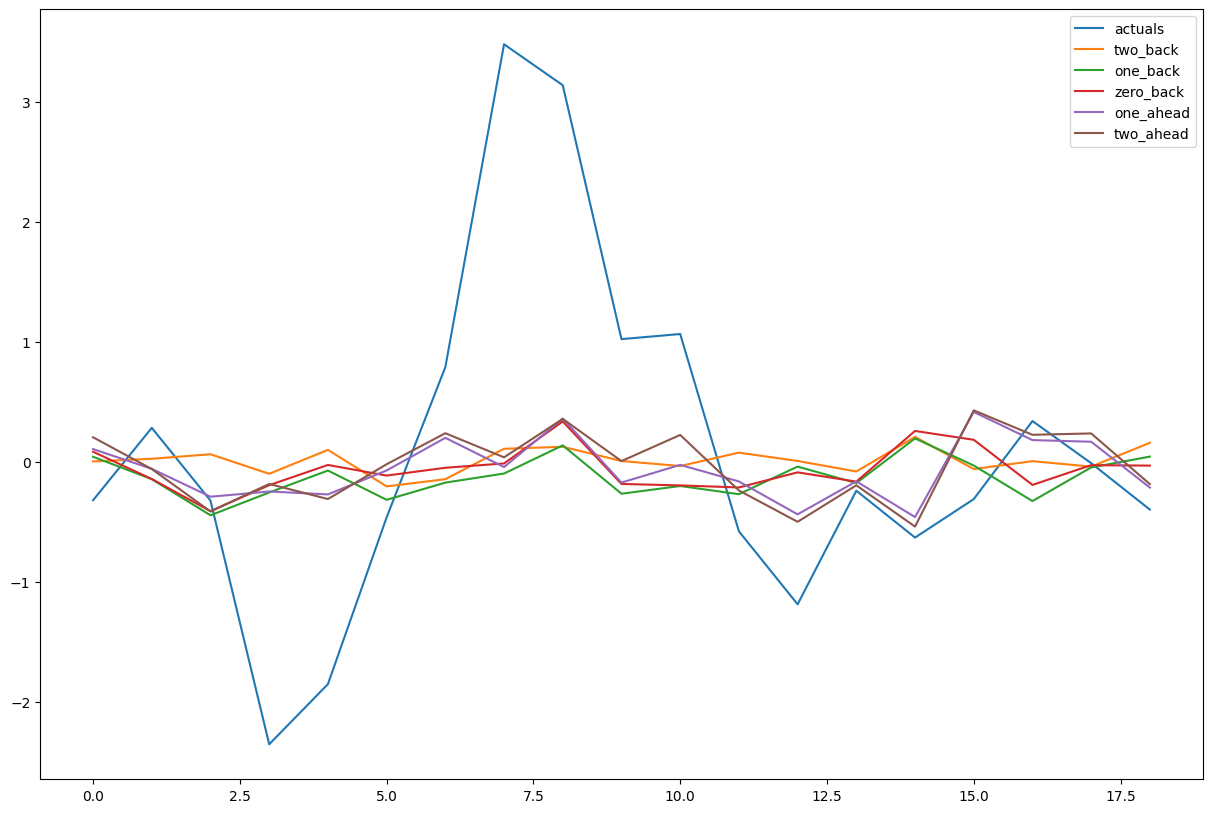

In [59]:
evaluate_xgboost(data = data, target_variable='egpiv', model_params=egpiv_opt, plot=1, save=1)

In [60]:
target_variable = 'construction'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
construction_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 04:52:51,789] A new study created in memory with name: no-name-4e87f805-4e8c-4ca2-b466-a9fe99e47c71
[I 2024-04-27 04:53:53,152] Trial 0 finished with value: 3.5396920135919316 and parameters: {'pval': 0.08544997552924093, 'n_estimators': 1100, 'eta': 0.901, 'max_depth': 3, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.9, 'colsample_bytree': 0.30000000000000004, 'flat': 4}. Best is trial 0 with value: 3.5396920135919316.
[I 2024-04-27 04:55:34,862] Trial 1 finished with value: 2.5718961343657494 and parameters: {'pval': 0.195509056958457, 'n_estimators': 1100, 'eta': 0.051000000000000004, 'max_depth': 5, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001, 'colsample_bytree': 0.5, 'flat': 3}. Best is trial 1 with value: 2.5718961343657494.
[I 2024-04-27 04:55:49,755] Trial 2 finished with value: 4.044304518159489 and parameters: {'pval': 0.025354906527349973, 'n_estimators': 500, 'eta': 0.901, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001, 'colsample

Best MAE=2.2507080396457857, best parameters:{'pval': 0.10113611807897702, 'n_estimators': 1300, 'eta': 0.201, 'max_depth': 5, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0, 'colsample_bytree': 0.6000000000000001, 'flat': 3}


In [61]:
optuna.visualization.plot_optimization_history(study)

In [62]:
optuna.visualization.plot_parallel_coordinate(study)

In [63]:
optuna.visualization.plot_slice(study, params = ['pval', 'n_estimators', 'eta', 'max_depth',
                    'reg_alpha', 'reg_lambda', 'flat'])

In [64]:
optuna.visualization.plot_param_importances(study)

In [9]:
construction_opt = {'pval': 0.10113611807897702, 'n_estimators': 1300, 'eta': 0.201, 'max_depth': 5, 'reg_alpha': 0.6, 'reg_lambda': 1.0, 'colsample_bytree': 0.6, 'flat': 3}

  Vintage    RMSE     MAE
0      -2  3.8257  3.2607
1      -1  3.6885  3.1059
2       0  3.5006  2.9504
3       1  3.5798  2.9866
4       2  2.9879  2.2507


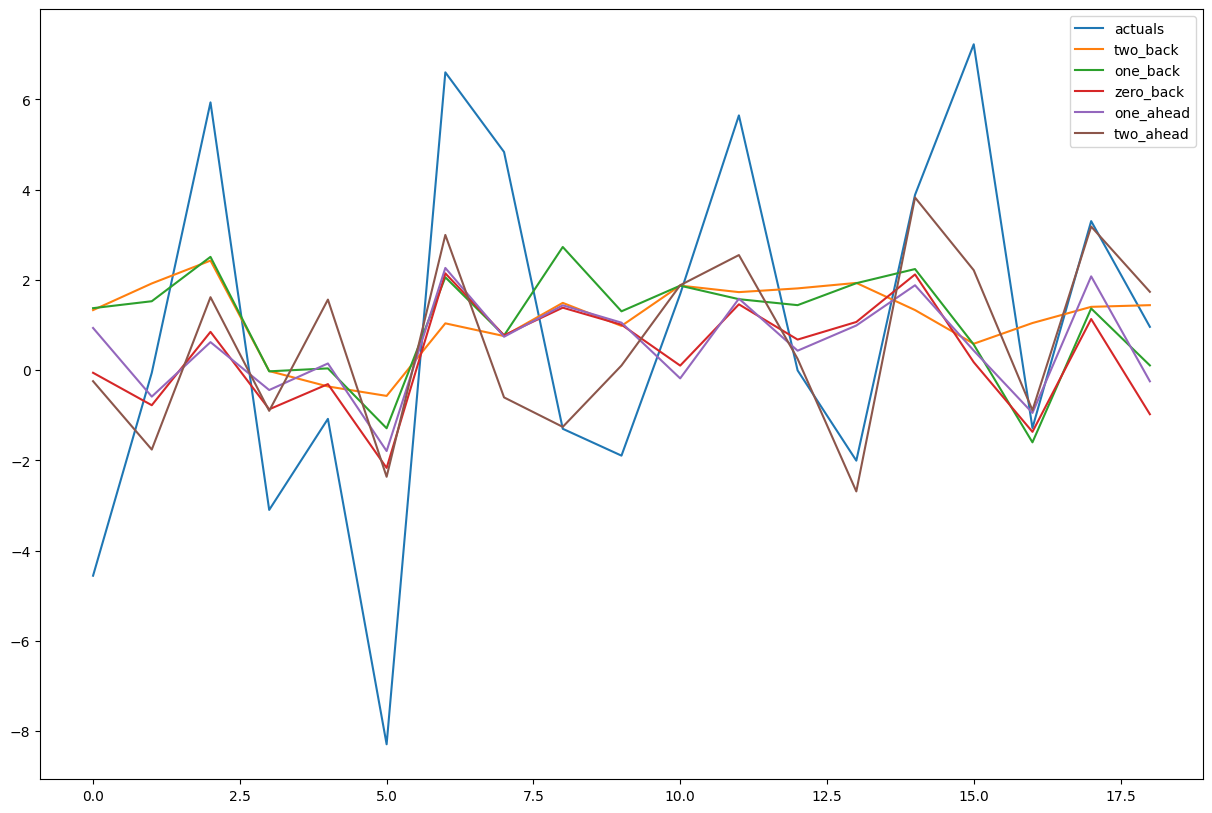

In [10]:
evaluate_xgboost(data = data, target_variable='construction', model_params=construction_opt, plot=1, save=1)

In [66]:
target_variable = 'trade'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
trade_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 08:20:16,493] A new study created in memory with name: no-name-80b038a5-13f5-4bf0-870d-2bf0c1fd5ca6
[I 2024-04-27 08:20:58,147] Trial 0 finished with value: 5.04611090411902 and parameters: {'pval': 0.013716675453660678, 'n_estimators': 1200, 'eta': 0.901, 'max_depth': 6, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001, 'colsample_bytree': 0.5, 'flat': 3}. Best is trial 0 with value: 5.04611090411902.
[I 2024-04-27 08:22:14,465] Trial 1 finished with value: 4.385724270066235 and parameters: {'pval': 0.14312379581836293, 'n_estimators': 800, 'eta': 0.15100000000000002, 'max_depth': 6, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001, 'colsample_bytree': 0.1, 'flat': 2}. Best is trial 1 with value: 4.385724270066235.
[I 2024-04-27 08:22:42,927] Trial 2 finished with value: 4.740427366018843 and parameters: {'pval': 0.017965261065653552, 'n_estimators': 600, 'eta': 0.051000000000000004, 'max_depth': 4, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004, 'colsample_bytr

Best MAE=3.852863827577543, best parameters:{'pval': 0.05576722583159301, 'n_estimators': 600, 'eta': 0.30100000000000005, 'max_depth': 3, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004, 'colsample_bytree': 0.1, 'flat': 3}


In [67]:
optuna.visualization.plot_optimization_history(study)

In [68]:
optuna.visualization.plot_parallel_coordinate(study)

In [69]:
optuna.visualization.plot_slice(study, params = ['pval', 'n_estimators', 'eta', 'max_depth',
                    'reg_alpha', 'reg_lambda', 'flat'])

In [70]:
optuna.visualization.plot_param_importances(study)

  Vintage    RMSE     MAE
0      -2  6.9257  4.6822
1      -1  6.8930  4.6336
2       0  7.1627  4.7084
3       1  5.7715  3.8381
4       2  5.7265  3.8529


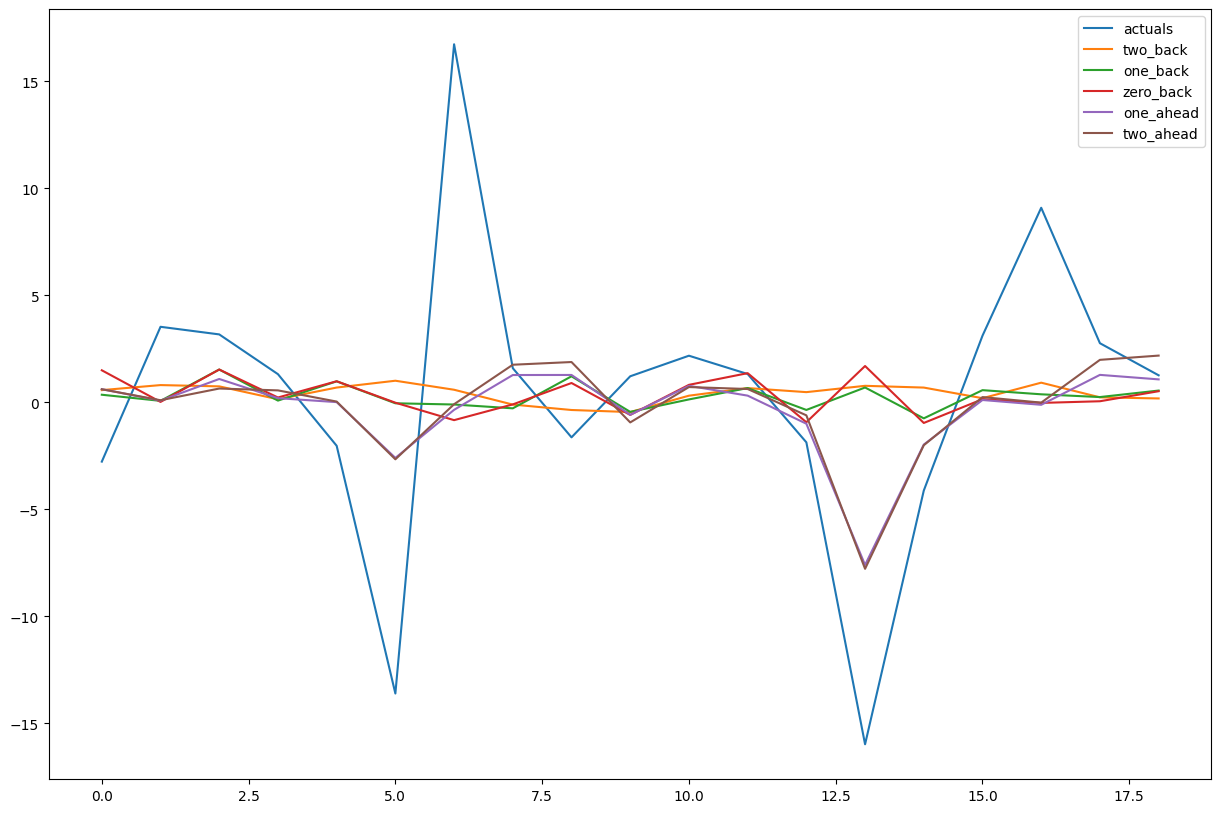

In [71]:
evaluate_xgboost(data = data, target_variable='trade', model_params=trade_opt, plot=1, save=1)

In [72]:
target_variable = 'transport'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
transport_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 10:56:43,774] A new study created in memory with name: no-name-e89ecf65-9825-4942-b565-d031087ef143
[I 2024-04-27 10:58:32,825] Trial 0 finished with value: 3.6633407220313017 and parameters: {'pval': 0.3864139688989478, 'n_estimators': 600, 'eta': 0.6010000000000001, 'max_depth': 6, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.30000000000000004, 'colsample_bytree': 0.1, 'flat': 3}. Best is trial 0 with value: 3.6633407220313017.
[I 2024-04-27 11:00:07,304] Trial 1 finished with value: 2.63945489901903 and parameters: {'pval': 0.14123194062793348, 'n_estimators': 1200, 'eta': 0.30100000000000005, 'max_depth': 6, 'reg_alpha': 0.2, 'reg_lambda': 0.9, 'colsample_bytree': 0.9, 'flat': 3}. Best is trial 1 with value: 2.63945489901903.
[I 2024-04-27 11:04:30,730] Trial 2 finished with value: 2.725376207517962 and parameters: {'pval': 0.42852572883009177, 'n_estimators': 1200, 'eta': 0.101, 'max_depth': 3, 'reg_alpha': 0.4, 'reg_lambda': 0.9, 'colsample_bytree': 0.300000000

Best MAE=2.396303864634632, best parameters:{'pval': 0.014888524056537905, 'n_estimators': 700, 'eta': 0.001, 'max_depth': 2, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'colsample_bytree': 0.30000000000000004, 'flat': 4}


In [73]:
optuna.visualization.plot_optimization_history(study)

In [74]:
optuna.visualization.plot_parallel_coordinate(study)

In [79]:
optuna.visualization.plot_slice(study, params = ['pval', 'n_estimators', 'eta', 'max_depth', 'colsample_bytree',
                    'reg_alpha', 'reg_lambda', 'flat'])

In [76]:
optuna.visualization.plot_param_importances(study)

In [ ]:
evaluate_xgboost(data = data, target_variable='transport', model_params=transport_opt, plot=1, save=1)

In [80]:
target_variable = 'finance'
study = optuna.create_study()
study.optimize(objective, n_trials = 75)
finance_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 19:23:39,873] A new study created in memory with name: no-name-3e557af9-f12b-43a9-ab4d-1b476c9d91bc
[I 2024-04-27 19:30:16,533] Trial 0 finished with value: 2.256308018930788 and parameters: {'pval': 0.9912018076053383, 'n_estimators': 700, 'eta': 0.15100000000000002, 'max_depth': 5, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'colsample_bytree': 1.0, 'flat': 4}. Best is trial 0 with value: 2.256308018930788.
[I 2024-04-27 19:31:19,738] Trial 1 finished with value: 1.995157353640199 and parameters: {'pval': 0.16578746989746765, 'n_estimators': 1000, 'eta': 0.251, 'max_depth': 3, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001, 'colsample_bytree': 0.1, 'flat': 2}. Best is trial 1 with value: 1.995157353640199.
[I 2024-04-27 19:31:44,982] Trial 2 finished with value: 2.0797347816772 and parameters: {'pval': 0.02981281097056155, 'n_estimators': 1100, 'eta': 0.7010000000000001, 'max_depth': 3, 'reg_alpha': 0.2, 'reg_lambda': 1.0, 'colsample_bytree': 0.9, 'flat': 2}. Best is trial

Best MAE=1.6847359539976572, best parameters:{'pval': 0.01445840655035963, 'n_estimators': 600, 'eta': 0.051000000000000004, 'max_depth': 4, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.30000000000000004, 'colsample_bytree': 0.5, 'flat': 4}


  Vintage    RMSE     MAE
0      -2  2.3244  1.9393
1      -1  2.1608  1.8067
2       0  2.0916  1.6829
3       1  2.2607  1.7026
4       2  2.2633  1.6847


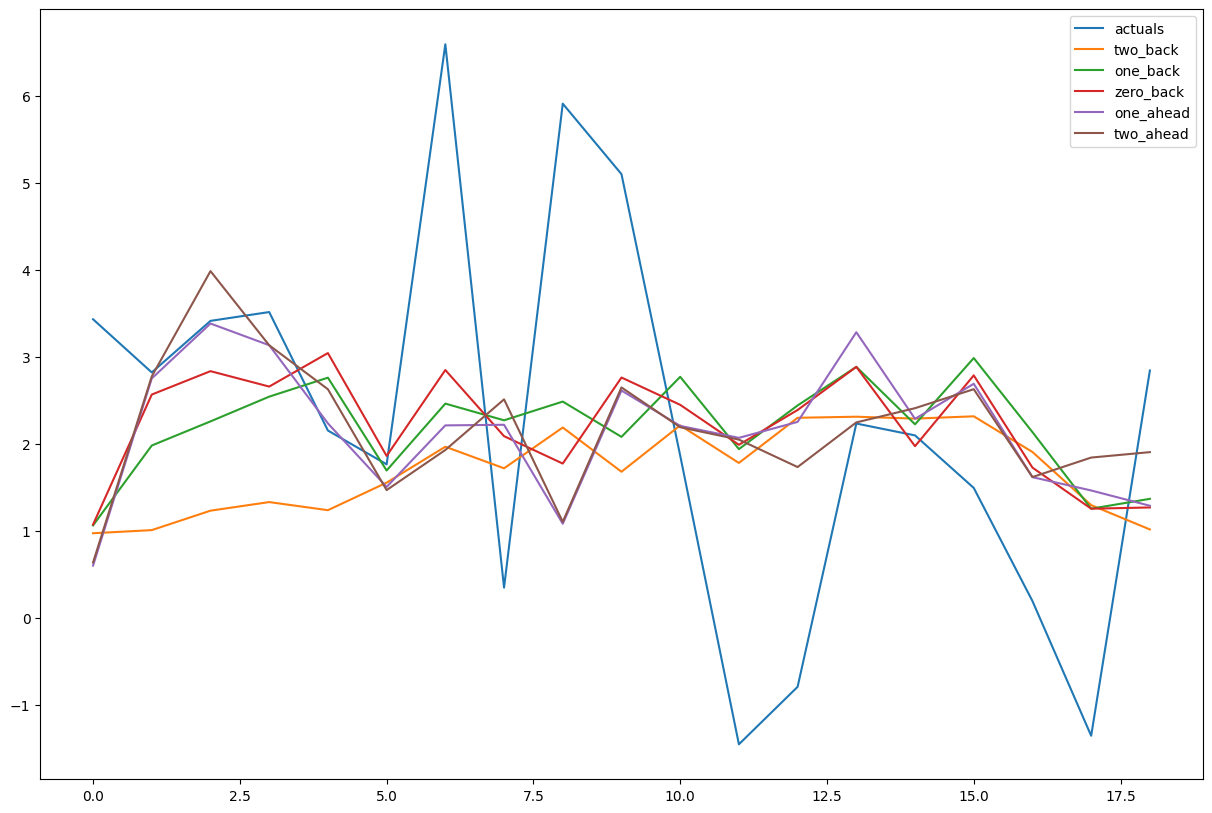

In [81]:
evaluate_xgboost(data = data, target_variable='finance', model_params=finance_opt, plot=1, save=1)

In [82]:
target_variable = 'real_estate'
study = optuna.create_study()
study.optimize(objective, n_trials = 75)
real_estate_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-27 21:10:52,910] A new study created in memory with name: no-name-cf019df0-44bf-4675-959f-845badf5b342
[I 2024-04-27 21:13:33,771] Trial 0 finished with value: 1.2524542631681537 and parameters: {'pval': 0.37273809229851484, 'n_estimators': 900, 'eta': 0.201, 'max_depth': 5, 'reg_alpha': 0.0, 'reg_lambda': 0.8, 'colsample_bytree': 0.2, 'flat': 3}. Best is trial 0 with value: 1.2524542631681537.
[I 2024-04-27 21:14:24,630] Trial 1 finished with value: 1.2301713293934928 and parameters: {'pval': 0.058397561418617, 'n_estimators': 900, 'eta': 0.7010000000000001, 'max_depth': 2, 'reg_alpha': 0.0, 'reg_lambda': 0.2, 'colsample_bytree': 1.0, 'flat': 2}. Best is trial 1 with value: 1.2301713293934928.
[I 2024-04-27 21:15:34,222] Trial 2 finished with value: 1.1212657659380751 and parameters: {'pval': 0.16859541182296764, 'n_estimators': 700, 'eta': 0.8510000000000001, 'max_depth': 3, 'reg_alpha': 0.8, 'reg_lambda': 0.2, 'colsample_bytree': 0.30000000000000004, 'flat': 2}. Best is t

Best MAE=0.8194678769238828, best parameters:{'pval': 0.058485040396537985, 'n_estimators': 1000, 'eta': 0.501, 'max_depth': 3, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'flat': 4}


  Vintage    RMSE     MAE
0      -2  1.1357  0.9043
1      -1  1.1281  0.8789
2       0  1.1383  0.8834
3       1  1.1654  0.8470
4       2  1.1615  0.8195


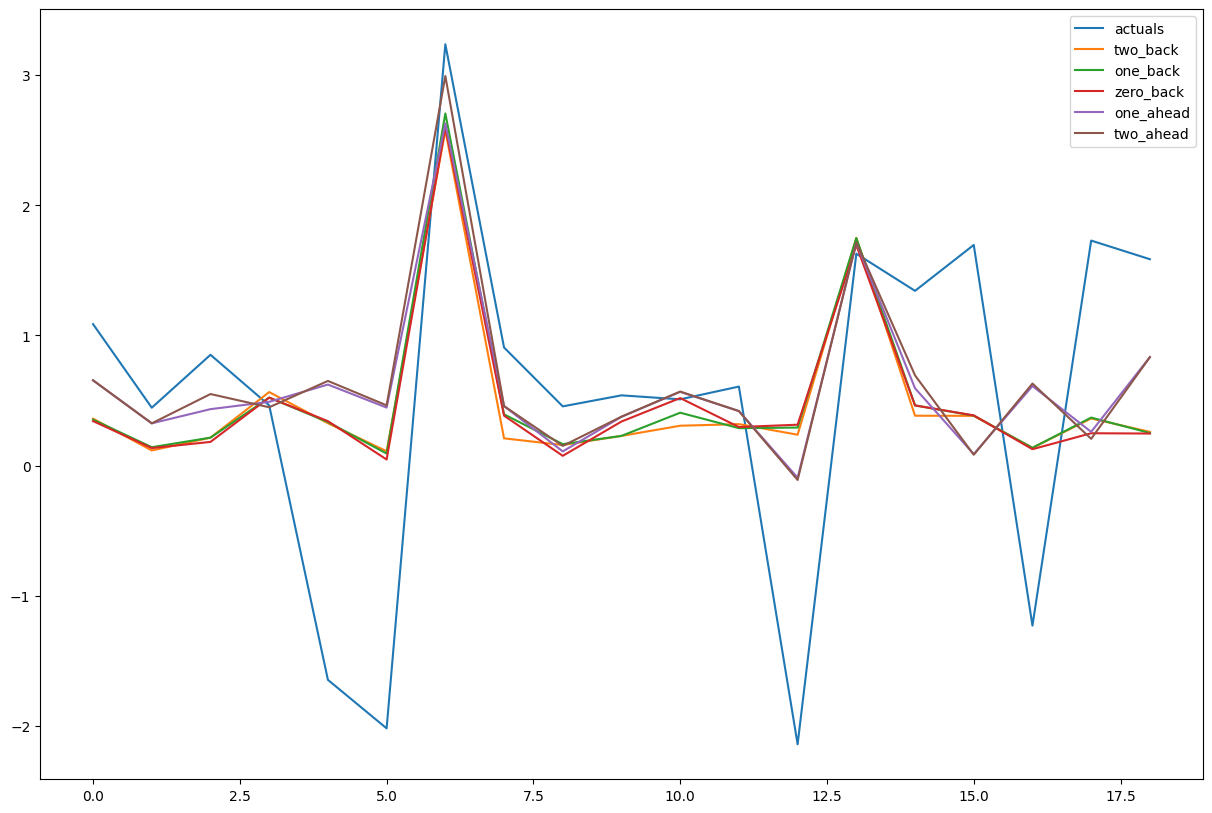

In [83]:
evaluate_xgboost(data = data, target_variable='real_estate', model_params=real_estate_opt, plot=1, save=1)

In [84]:
target_variable = 'others'
study = optuna.create_study()
study.optimize(objective, n_trials = 75)
others_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 00:28:44,246] A new study created in memory with name: no-name-0c9f75db-6a2d-4f90-8317-45bb44ded0d3
[I 2024-04-28 00:30:09,980] Trial 0 finished with value: 3.560696398578082 and parameters: {'pval': 0.22049348945601108, 'n_estimators': 800, 'eta': 0.451, 'max_depth': 4, 'reg_alpha': 0.2, 'reg_lambda': 0.4, 'colsample_bytree': 0.5, 'flat': 3}. Best is trial 0 with value: 3.560696398578082.
[I 2024-04-28 00:33:10,285] Trial 1 finished with value: 4.108402300793673 and parameters: {'pval': 0.4843464400898359, 'n_estimators': 1000, 'eta': 0.8510000000000001, 'max_depth': 5, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004, 'colsample_bytree': 0.0, 'flat': 3}. Best is trial 0 with value: 3.560696398578082.
[I 2024-04-28 00:36:52,735] Trial 2 finished with value: 3.6057923630547215 and parameters: {'pval': 0.3326484833237101, 'n_estimators': 1300, 'eta': 0.201, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.7000000000000001, 'flat': 4}. Best is t

Best MAE=2.970761247529305, best parameters:{'pval': 0.04465719158436794, 'n_estimators': 1000, 'eta': 0.501, 'max_depth': 3, 'reg_alpha': 1.0, 'reg_lambda': 0.9, 'colsample_bytree': 0.0, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  4.8636  3.3863
1      -1  4.8021  3.3069
2       0  4.5154  2.9609
3       1  4.4003  2.9868
4       2  4.3988  2.9708


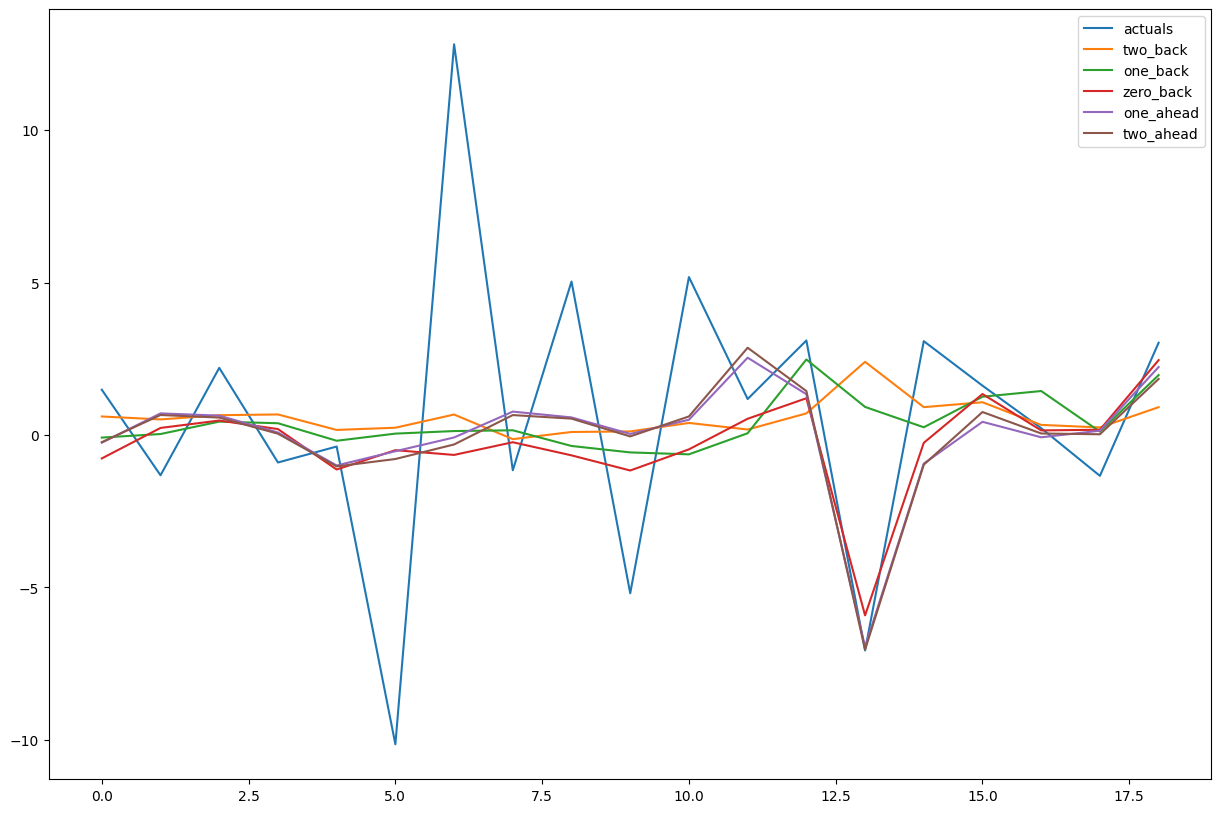

In [85]:
evaluate_xgboost(data = data, target_variable='others', model_params=others_opt, plot=1, save=1)

In [86]:
target_variable = 'taxes'
study = optuna.create_study()
study.optimize(objective, n_trials = 75)
taxes_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 01:58:14,891] A new study created in memory with name: no-name-0003e112-6e5c-4c94-ac12-dac8752bba1d
[I 2024-04-28 02:00:20,252] Trial 0 finished with value: 2.624096442810198 and parameters: {'pval': 0.058959229535765746, 'n_estimators': 1100, 'eta': 0.251, 'max_depth': 6, 'reg_alpha': 0.9, 'reg_lambda': 0.1, 'colsample_bytree': 0.0, 'flat': 4}. Best is trial 0 with value: 2.624096442810198.
[I 2024-04-28 02:05:03,069] Trial 1 finished with value: 2.3036279732137794 and parameters: {'pval': 0.7476720486948917, 'n_estimators': 1200, 'eta': 0.30100000000000005, 'max_depth': 4, 'reg_alpha': 0.9, 'reg_lambda': 1.0, 'colsample_bytree': 0.9, 'flat': 2}. Best is trial 1 with value: 2.3036279732137794.
[I 2024-04-28 02:06:00,275] Trial 2 finished with value: 2.5205855824866945 and parameters: {'pval': 0.013183488756177066, 'n_estimators': 900, 'eta': 0.6010000000000001, 'max_depth': 6, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.0, 'colsample_bytree': 0.5, 'flat': 4}. Best 

Best MAE=2.005893983771883, best parameters:{'pval': 0.03260991088678925, 'n_estimators': 500, 'eta': 0.751, 'max_depth': 4, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001, 'flat': 4}


  Vintage    RMSE     MAE
0      -2  3.6284  2.4599
1      -1  3.6732  2.5364
2       0  3.6929  2.5217
3       1  3.1632  2.0005
4       2  3.0131  2.0059


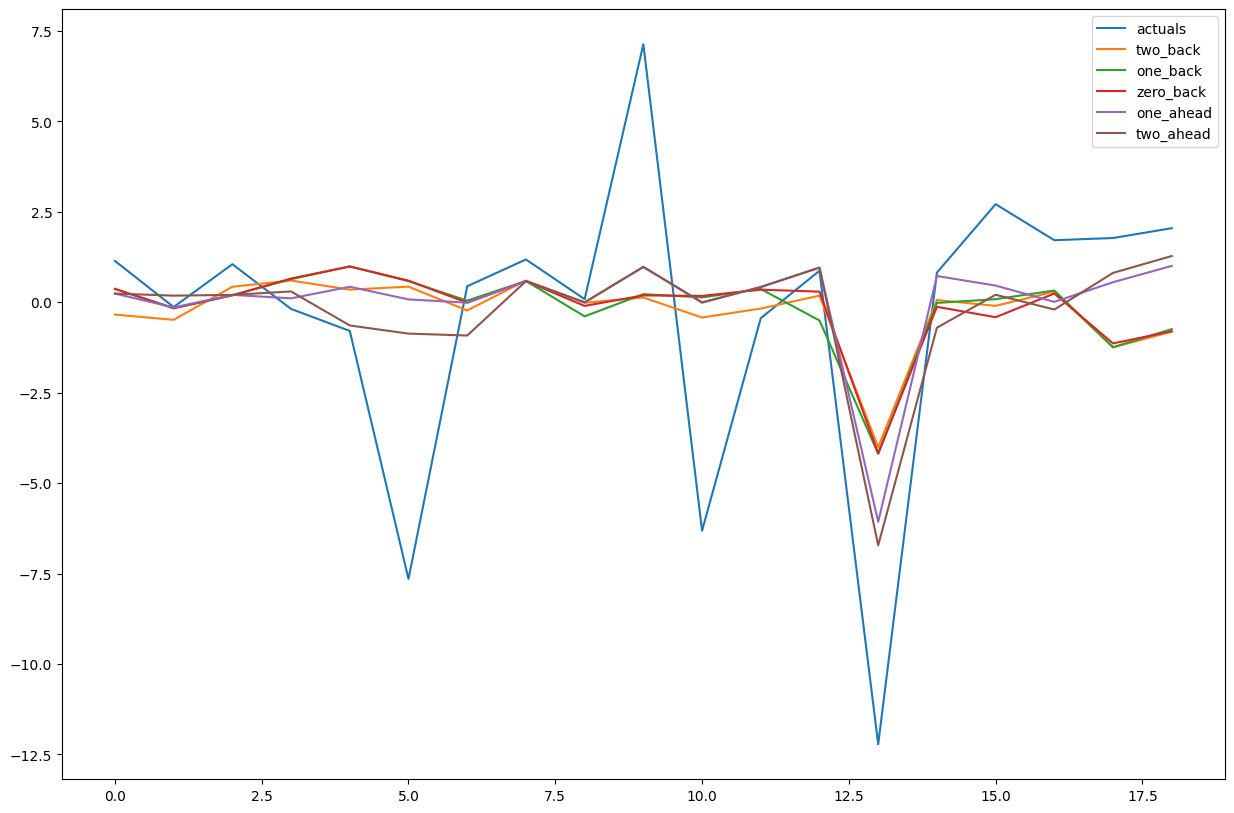

In [87]:
evaluate_xgboost(data = data, target_variable='taxes', model_params=taxes_opt, plot=1, save=1)